# TF isoform data


## TODO

- check valid clones only in all data
- get sequence information
- remove partners that didn't test positive with any isoform
- remove single isoforms
    - but need to add first to paralogs
- Look into effect of number of PPIs per TF
- combine categories to get paralog data

In [15]:
import os
from itertools import combinations

import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

import ccsblib
from ccsblib import ccsbplotlib as cplt

from data_loading import (load_isoform_and_paralog_y2h_data,
                          load_y1h_pdi_data,
                          load_m1h_activation_data,
                          load_valid_isoform_clones,
                          load_rna_expression_data)
from isoform_pairwise_metrics import pairs_of_isoforms_comparison_table

%matplotlib inline

In [16]:
y2h = load_isoform_and_paralog_y2h_data()
y1h = load_y1h_pdi_data()
m1h = load_m1h_activation_data()
# rna = load_rna_expression_data()
isoforms = load_valid_isoform_clones()
iso_pairs = pairs_of_isoforms_comparison_table(isoforms=isoforms,
                                               y2h=y2h,
                                               y1h=y1h,
                                               m1h=m1h)

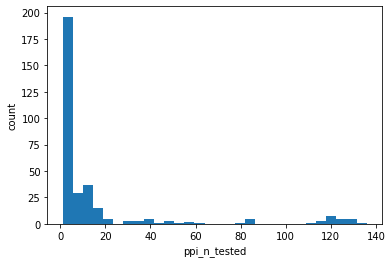

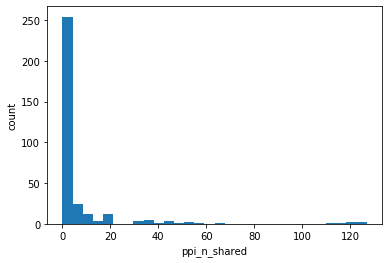

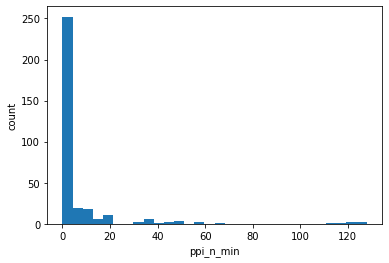

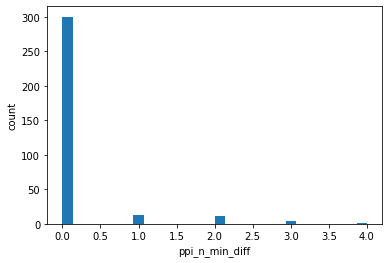

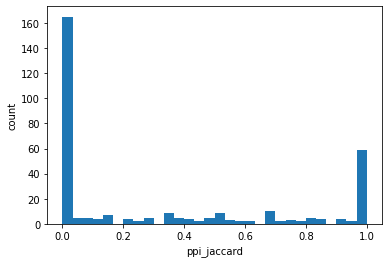

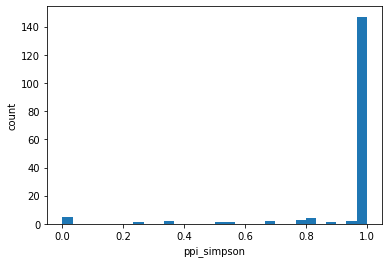

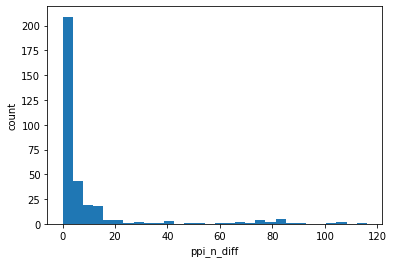

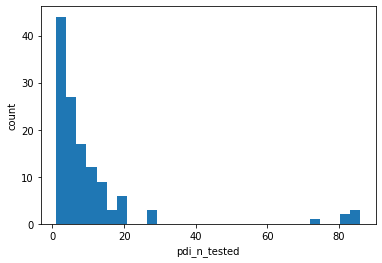

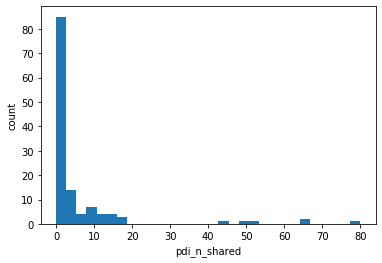

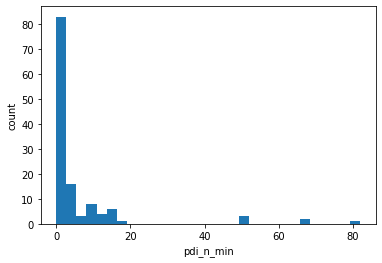

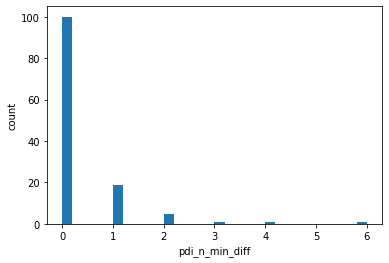

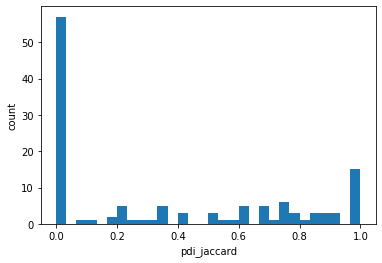

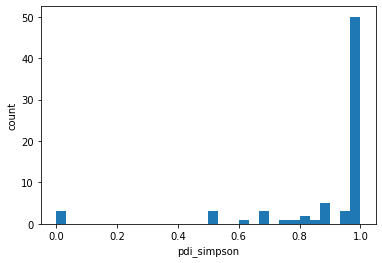

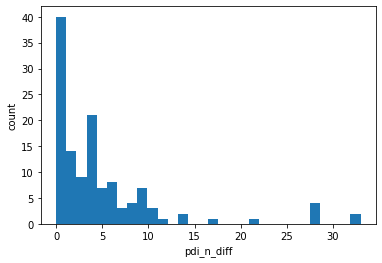

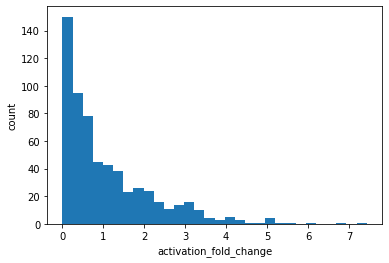

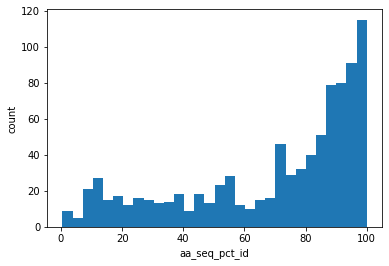

In [14]:
for col in iso_pairs.columns[4:]:
    plt.hist(iso_pairs[col], bins=30)
    plt.xlabel(col)
    plt.ylabel('count')
    plt.show()

In [3]:
iso_pairs.head()

,tf_gene_symbol,clone_acc_a,clone_acc_b,pair,ppi_n_tested,ppi_n_shared,ppi_n_min,ppi_n_min_diff,ppi_jaccard,ppi_simpson,ppi_n_diff,pdi_n_tested,pdi_n_shared,pdi_n_min,pdi_n_min_diff,pdi_jaccard,pdi_simpson,pdi_n_diff,activation_fold_change,aa_seq_pct_id
0,AEBP2,AEBP2|2/3|05F03,AEBP2|3/3|05E07,AEBP2|2/3|05F03_AEBP2|3/3|05E07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.535619,82.0
1,ARNT2,ARNT2|1/6|08C12,ARNT2|2/6|09E01,ARNT2|1/6|08C12_ARNT2|2/6|09E01,9.0,5.0,5.0,0.0,0.555556,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.094800,93.0
2,ARNT2,ARNT2|1/6|08C12,ARNT2|3/6|10D11,ARNT2|1/6|08C12_ARNT2|3/6|10D11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.7
3,ARNT2,ARNT2|2/6|09E01,ARNT2|3/6|10D11,ARNT2|2/6|09E01_ARNT2|3/6|10D11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.1
4,ARNTL,ARNTL|1/2|08H08,ARNTL|2/2|08E08,ARNTL|1/2|08H08_ARNTL|2/2|08E08,2.0,0.0,0.0,0.0,0.000000,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.3


### Explore PDI/PPI profile differences and sequence similarity

Look into:
- PPI and PDI Jaccard distribution
  - Faceted by degree
- PPI versus PDI Jaccard/Simpson
  - Faceted by number of interactors
- PPI/PDI Jaccard versus sequence similarity

TODO
- Compare randomly selected isoforms from different genes (from paralog data)

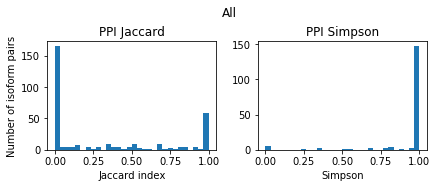

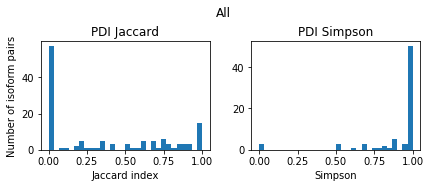

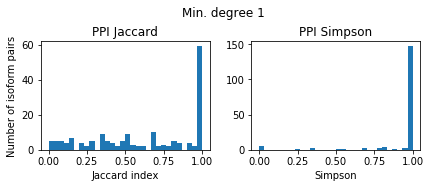

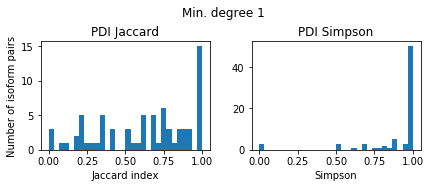

In [17]:
#  Jaccard/Simpson for PPI/PDI, histograms
def make_jaccard_simpson_hist(int_type, iso_pairs=iso_pairs, main_title='', nb=30):
    # int_type - ppi or pdi
    # nb - number of bins
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,2.5))
    fig.suptitle(main_title)
    fig.tight_layout(rect=[0, 0.03, 1, 0.87]) # adjust to allow for subtitle

    ax1.hist(iso_pairs[int_type + '_jaccard'], bins=nb)
    ax1.set_title(int_type.upper() + ' Jaccard')
    ax1.set_xlabel('Jaccard index')
    ax1.set_ylabel('Number of isoform pairs')
    
    ax2.hist(iso_pairs[int_type + '_simpson'], bins=nb)
    ax2.set_title(int_type.upper() + ' Simpson')
    ax2.set_xlabel('Simpson')
    
make_jaccard_simpson_hist('ppi', iso_pairs, 'All')
make_jaccard_simpson_hist('pdi', iso_pairs, 'All')
make_jaccard_simpson_hist('ppi', iso_pairs.loc[iso_pairs['ppi_n_min']>=1, :], main_title='Min. degree 1')
make_jaccard_simpson_hist('pdi', iso_pairs.loc[iso_pairs['pdi_n_min']>=1, :], main_title='Min. degree 1')


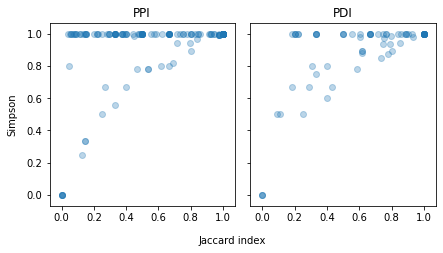

In [18]:
# Jaccard vs Simpson for PPI and PDI
def make_jaccard_simpson_plot(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)

    alpha=0.3
    ax1.scatter(df.ppi_jaccard, df.ppi_simpson, alpha=alpha)
    ax1.set_title('PPI')
    ax1.set_aspect('equal')
    ax2.scatter(df.pdi_jaccard, df.pdi_simpson, alpha=alpha)
    ax2.set_title('PDI')
    ax2.set_aspect('equal')

    fig.tight_layout()
    fig.text(0.5, 0.05, 'Jaccard index', ha='center')
    fig.text(-0.02, 0.5, 'Simpson', va='center', rotation='vertical')

make_jaccard_simpson_plot(iso_pairs) # only plotted for cases  with 1+ interactions for both iso. of a pair

SpearmanrResult(correlation=nan, pvalue=nan)

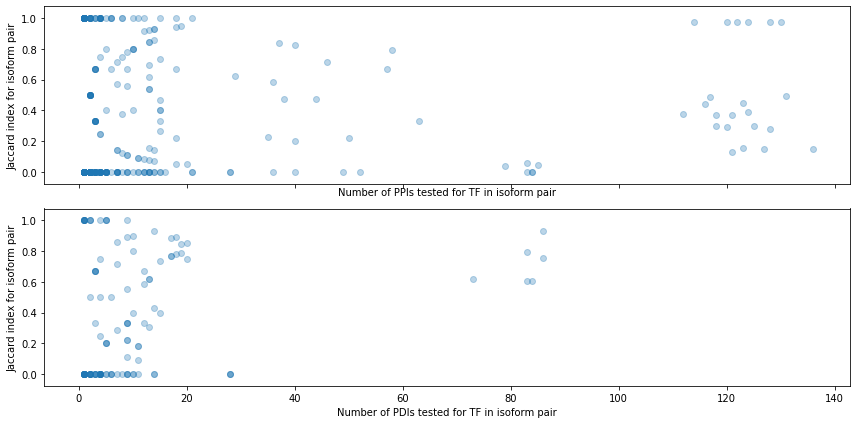

In [21]:
# Is there a relationship between degree and interaction profile similarity?
# For now use number of pdi/ppi tested as estimate of degree.
fig, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True, figsize=(12,6))
alpha=0.3

ax1.scatter(iso_pairs.ppi_n_tested, iso_pairs.ppi_jaccard, alpha=alpha)
ax1.set_xlabel('Number of PPIs tested for TF in isoform pair')
ax1.set_ylabel('Jaccard index for isoform pair')

ax2.scatter(iso_pairs.pdi_n_tested, iso_pairs.pdi_jaccard, alpha=alpha)
ax2.set_xlabel('Number of PDIs tested for TF in isoform pair')
ax2.set_ylabel('Jaccard index for isoform pair')

fig.tight_layout()

# Luke question - how to determine if there is no bias between degree and Jaccard?
stats.spearmanr(iso_pairs.ppi_n_tested, iso_pairs.ppi_jaccard)
stats.spearmanr(iso_pairs.pdi_n_tested, iso_pairs.pdi_jaccard)

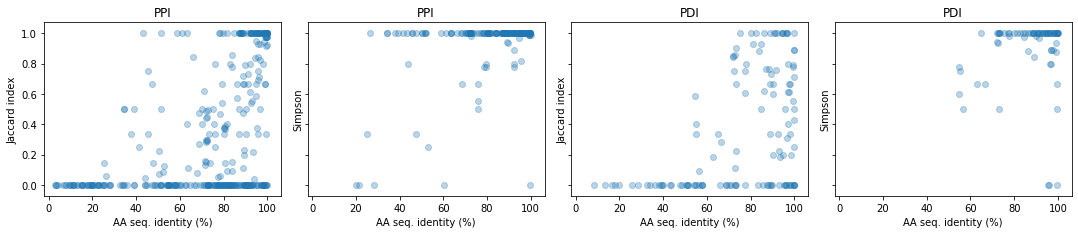

In [7]:
# Jaccard/Simpson versus similarity for PPI and PDI
def make_profile_diff_vs_seq_plot(df):
    fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(15,3))
    fig.tight_layout()
    (ax1, ax2, ax3, ax4) = axs
    
    for ax in axs: ax.set_xlabel('AA seq. identity (%)')
        
    alpha=0.3
    
    ax1.scatter(df.aa_seq_pct_id, df.ppi_jaccard, alpha=alpha)
    ax1.set_title('PPI')
    ax1.set_ylabel('Jaccard index')
    ax2.scatter(df.aa_seq_pct_id, df.ppi_simpson, alpha=alpha)
    ax2.set_title('PPI')
    ax2.set_ylabel('Simpson')
    ax3.scatter(df.aa_seq_pct_id, df.pdi_jaccard, alpha=alpha)
    ax3.set_title('PDI')
    ax3.set_ylabel('Jaccard index')
    ax4.scatter(df.aa_seq_pct_id, df.pdi_simpson, alpha=alpha)
    ax4.set_title('PDI')
    ax4.set_ylabel('Simpson')

make_profile_diff_vs_seq_plot(iso_pairs)

Text(27.125, 0.5, 'M1H activation fold change')

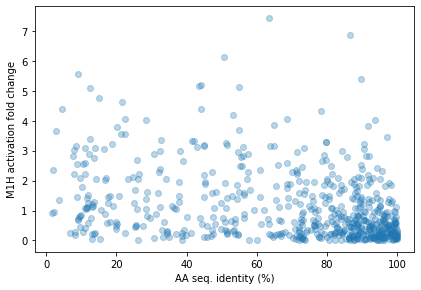

In [8]:
# Jaccard/Simpson versus similarity for M1H
fig, ax1 = plt.subplots(1, sharex=True, sharey=True)
fig.tight_layout()
alpha=0.3
ax1.scatter(iso_pairs.aa_seq_pct_id, iso_pairs.activation_fold_change, alpha=alpha)
ax1.set_xlabel('AA seq. identity (%)')
ax1.set_ylabel('M1H activation fold change')

In [23]:
# get isoform-specific y1h and y2h degree
deg = y1h.loc[:, y1h.columns[2:]].sum(axis=1).rename('y1h_degree')
y1h_nd = y1h[['tf', 'unique_acc']].join(deg, how='left')
y2h_nd = y2h.loc[y2h.category=='tf_isoform_ppis', :].groupby('ad_clone_acc')['ad_clone_acc'].count().rename('y2h_degree')
int_nd = y1h_nd.join(y2h_nd, how='outer', on='unique_acc')
int_nd.head()

,tf,unique_acc,y1h_degree,y2h_degree
162.0,CREB1,CREB1|1/2|02E01,0.0,1.0
0.0,CREB1,CREB1|2/2|01F12,3.0,1.0
1.0,DLX1,DLX1|1/2|07A12,9.0,NaN
174.0,DLX1,DLX1|2/2|07E09,0.0,NaN
2.0,DLX4,DLX4|1/3|11A04,3.0,1.0


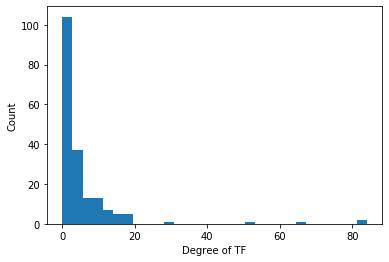

Text(0, 0.5, 'Count')

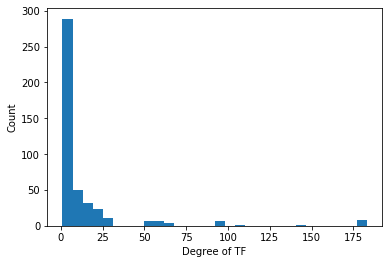

In [29]:
# plot the degree distributions
# degere of y1h
plt.hist(int_nd.y1h_degree.dropna(), bins=30) 
plt.xlabel('Degree of TF')
plt.ylabel('Count')
plt.show()
plt.hist(int_nd.y2h_degree.dropna(), bins=30) 
plt.xlabel('Degree of TF')
plt.ylabel('Count')

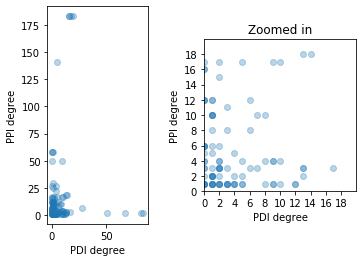

In [12]:
# compare pdi versus ppi degree
fig, (ax1, ax2) = plt.subplots(1,2)
alpha = 0.3

ax1.scatter(int_nd.y1h_degree, int_nd.y2h_degree, alpha=alpha)
ax1.set_aspect('equal')
ax1.set_xlabel('PDI degree')
ax1.set_ylabel('PPI degree')

ax2.scatter(int_nd.y1h_degree, int_nd.y2h_degree, alpha=alpha)
ax2.set_aspect('equal')
ax2.set_xlabel('PDI degree')
ax2.set_ylabel('PPI degree')
ax2.set_title('Zoomed in')
ax2.set_xlim(0,20)
ax2.set_xticks(range(0,20,2))
ax2.set_ylim(0,20)
ax2.set_yticks(range(0,20,2));
# ax2.set_yscale('log')
# ax2.set_xscale('log')


SpearmanrResult(correlation=-0.26507906812599813, pvalue=1.321168465578112e-05)

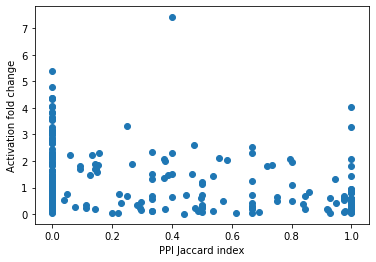

In [32]:
x = 'ppi_jaccard'
y = 'activation_fold_change'
xy = iso_pairs.loc[iso_pairs[x].notnull() & iso_pairs[y].notnull(), :]
plt.scatter(xy[x], xy[y])
plt.xlabel('PPI Jaccard index')
plt.ylabel('Activation fold change')
stats.spearmanr(xy[x], xy[y])

(104, 20)


SpearmanrResult(correlation=-0.2500113196982098, pvalue=0.010479425843809722)

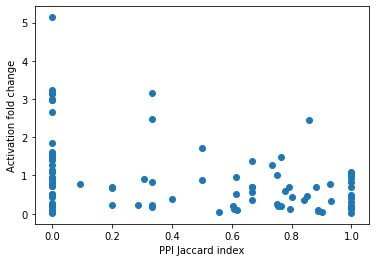

In [33]:
x = 'pdi_jaccard'
y = 'activation_fold_change'
xy = iso_pairs.loc[iso_pairs[x].notnull() & iso_pairs[y].notnull(), :]
print(xy.shape)
plt.scatter(xy[x], xy[y])
plt.xlabel('PPI Jaccard index')
plt.ylabel('Activation fold change')
stats.spearmanr(xy[x], xy[y])

(61, 20)


SpearmanrResult(correlation=0.24032405310412527, pvalue=0.06209683094347522)

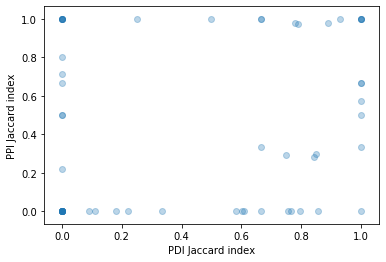

In [34]:
x = 'pdi_jaccard'
y = 'ppi_jaccard'
xy = iso_pairs.loc[iso_pairs[x].notnull() & iso_pairs[y].notnull(), :]
print(xy.shape)
plt.scatter(xy[x], xy[y],
            alpha=0.3)
plt.xlabel('PDI Jaccard index')
plt.ylabel('PPI Jaccard index')
stats.spearmanr(xy[x], xy[y])

In [40]:
x = 'pdi_jaccard'
y = 'ppi_jaccard'
print(iso_pairs['ppi_n_min']>=1)
print(iso_pairs[x].notnull())

0      False
1       True
2      False
3      False
4      False
       ...  
895    False
896    False
897    False
898    False
899     True
Name: ppi_n_min, Length: 900, dtype: bool
0      False
1      False
2      False
3      False
4      False
       ...  
895    False
896    False
897    False
898    False
899    False
Name: pdi_jaccard, Length: 900, dtype: bool


(24, 20)


SpearmanrResult(correlation=-0.2654905605568716, pvalue=0.20989687268470955)

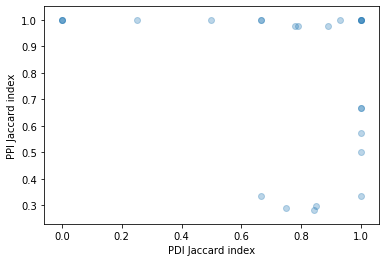

In [44]:
xy = iso_pairs.loc[iso_pairs[x].notnull() & iso_pairs[y].notnull() & (iso_pairs['ppi_n_min']>=1) & (iso_pairs['pdi_n_min']>=1), :]
print(xy.shape)
plt.scatter(xy[x], xy[y],
            alpha=0.3)
plt.xlabel('PDI Jaccard index')
plt.ylabel('PPI Jaccard index')
stats.spearmanr(xy[x], xy[y])

In [16]:
# Look at direction of activation change? I.e. is the isoform with less binding partners
# the one with activation closer to 0?

In [17]:
iso_pairs.sort_values('ppi_n_min_diff',
                      ascending=False).head(20)

,tf_gene_symbol,clone_acc_a,clone_acc_b,pair,ppi_n_tested,ppi_n_shared,ppi_n_min,ppi_n_min_diff,ppi_jaccard,ppi_simpson,ppi_n_diff,pdi_n_tested,pdi_n_shared,pdi_n_min,pdi_n_min_diff,pdi_jaccard,pdi_simpson,pdi_n_diff,activation_fold_change,aa_seq_pct_id
644,ZBTB44,ZBTB44|1/9|12B06,ZBTB44|4/9|10H06,ZBTB44|1/9|12B06_ZBTB44|4/9|10H06,15.0,5.0,9.0,4.0,0.333333,0.555556,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.324958,76.0
354,PATZ1,PATZ1|1/4|02C02,PATZ1|3/4|02A04,PATZ1|1/4|02C02_PATZ1|3/4|02A04,18.0,12.0,15.0,3.0,0.666667,0.800000,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.239169,79.4
513,TCF4,TCF4|5/9|07C02,TCF4|7/9|07G03,TCF4|5/9|07C02_TCF4|7/9|07G03,58.0,46.0,49.0,3.0,0.793103,0.938776,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.090708,89.8
645,ZBTB44,ZBTB44|1/9|12B06,ZBTB44|5/9|10H05,ZBTB44|1/9|12B06_ZBTB44|5/9|10H05,15.0,6.0,9.0,3.0,0.400000,0.666667,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.493713,75.8
811,ZNF451,ZNF451|6/8|05H11,ZNF451|7/8|06D01,ZNF451|6/8|05H11_ZNF451|7/8|06D01,8.0,1.0,4.0,3.0,0.125000,0.250000,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.485041,52.9
587,TFEC,TFEC|2/6|04A02,TFEC|5/6|04A01,TFEC|2/6|04A02_TFEC|5/6|04A01,5.0,0.0,2.0,2.0,0.000000,0.000000,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.4
514,TCF4,TCF4|5/9|07C02,TCF4|8/9|07A05,TCF4|5/9|07C02_TCF4|8/9|07A05,46.0,33.0,35.0,2.0,0.717391,0.942857,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.825006,89.1
643,ZBTB44,ZBTB44|1/9|12B06,ZBTB44|3/9|10B06,ZBTB44|1/9|12B06_ZBTB44|3/9|10B06,15.0,7.0,9.0,2.0,0.466667,0.777778,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.525376,78.6
655,ZBTB44,ZBTB44|3/9|10B06,ZBTB44|6/9|12H02,ZBTB44|3/9|10B06_ZBTB44|6/9|12H02,13.0,9.0,11.0,2.0,0.692308,0.818182,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.080167,95.7
801,ZNF451,ZNF451|3/8|06A03,ZNF451|6/8|05H11,ZNF451|3/8|06A03_ZNF451|6/8|05H11,7.0,1.0,3.0,2.0,0.142857,0.333333,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.201770,47.6


In [18]:
# Check if this result is robust against requiring at least
# one interaction partner for both genes.
# To see if the effect is driven by non-functional isoforms.
x = 'ppi_jaccard'
y = 'activation_fold_change'
xy = iso_pairs.loc[iso_pairs[x].notnull() &
                   iso_pairs[y].notnull() &
                   (iso_pairs['ppi_n_min'] >= 1), :]
print(xy.shape)
stats.spearmanr(xy[x], xy[y])

(142, 20)


SpearmanrResult(correlation=-0.26863098874853214, pvalue=0.0012273703760291082)

In [19]:
xy.sort_values('activation_fold_change', ascending=False).head()

,tf_gene_symbol,clone_acc_a,clone_acc_b,pair,ppi_n_tested,ppi_n_shared,ppi_n_min,ppi_n_min_diff,ppi_jaccard,ppi_simpson,ppi_n_diff,pdi_n_tested,pdi_n_shared,pdi_n_min,pdi_n_min_diff,pdi_jaccard,pdi_simpson,pdi_n_diff,activation_fold_change,aa_seq_pct_id
47,E2F3,E2F3|2/4|10A08,E2F3|3/4|10B08,E2F3|2/4|10A08_E2F3|3/4|10B08,5.0,2.0,2.0,0.0,0.4,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.433645,63.4
331,NR4A1,NR4A1|1/5|03A04,NR4A1|2/5|03G05,NR4A1|1/5|03A04_NR4A1|2/5|03G05,1.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.029137,93.6
21,ATF2,ATF2|3/6|09C05,ATF2|5/6|09A05,ATF2|3/6|09C05_ATF2|5/6|09A05,3.0,0.0,1.0,1.0,0.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.012971,28.3
23,ATF2,ATF2|4/6|09B05,ATF2|5/6|09A05,ATF2|4/6|09B05_ATF2|5/6|09A05,4.0,0.0,1.0,1.0,0.0,0.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.793690,20.3
888,ZSCAN18,ZSCAN18|1/7|09F02,ZSCAN18|2/7|09A01,ZSCAN18|1/7|09F02_ZSCAN18|2/7|09A01,16.0,0.0,2.0,2.0,0.0,0.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.572874,21.4
